In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize

import seaborn as sns

import numpy as np
import pandas as pd

from tqdm import tqdm
import torch

from torch.utils.data import DataLoader


import sys
sys.path.append('../src')
sys.path.append('../experiments_angle/')

### Notes from initial runs


Starting simple, moving more complex:
#### Single image
1. Concentrated distributions are much easier to learn: they start from a lower baseline.
2. All distributions converge within 100 epochs

#### Many images
- Eval loss starts around the same place as the correspondingly concentrated single image: good initial indication.
- Seems to learn successfully initially.
- Train and validation losses both appear to plateau around 0.15. Probably a sign that we should unfreeze there.
- output norm stay well behaved. It is small, but not overly so.

#### Many images - flat distribution
- fast learning initially.
- achieves about 0.15 train and validation losses

#### Training the ResNet:
- learning rate 1E-5 is too large: learned performance vanishes within the first 20 steps, norm blows up
- learning rate 1E-6 is reasonable: performance increases.
- Achieves very good validation performance ~0.002

## Trying out the SVM for discrimination performance

In [2]:
from models.face_angle import EstimateAngle
from data.rotated_faces import ConsistentRotationDataset, RotatedFacesDataset
from pytorch_lightning import Trainer

model_ckpt = '../experiments_angle/2025-10-17(00:20:29)-fullnetwork/checkpoints/best.ckpt'

model = EstimateAngle.load_from_checkpoint(model_ckpt)


W1022 18:31:02.643000 17784 torch/distributed/elastic/multiprocessing/redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


import error: No module named 'triton'


#### Double check the numbers from wandb curves

In [3]:
ds = RotatedFacesDataset(loc=0, kappa=0.1, split='valid')
dl = DataLoader(ds, batch_size=32)
trainer = Trainer()
trainer.test(model, dl)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/luke/.local/defaultPythonEnv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |                                                | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/loss         │   0.0021671114955097437   │
└───────────────────────────┴───────────────────────────┘

[{'test/loss': 0.0021671114955097437}]

Looks good.

## Compare output embeddings

In [3]:
ds1 = ConsistentRotationDataset(0., split='valid')
ds2 = ConsistentRotationDataset(0.1, split='valid')

In [4]:
dl1 = torch.utils.data.DataLoader(ds1, batch_size=256, shuffle=False)
dl2 = torch.utils.data.DataLoader(ds2, batch_size=256, shuffle=False)

In [5]:
imgs1, _ = next(iter(dl1))
imgs2, _ = next(iter(dl2))

In [6]:
embeddings_1 = model.forward(imgs1.to('mps')).detach().cpu()
embeddings_2 = model.forward(imgs2.to('mps')).detach().cpu()

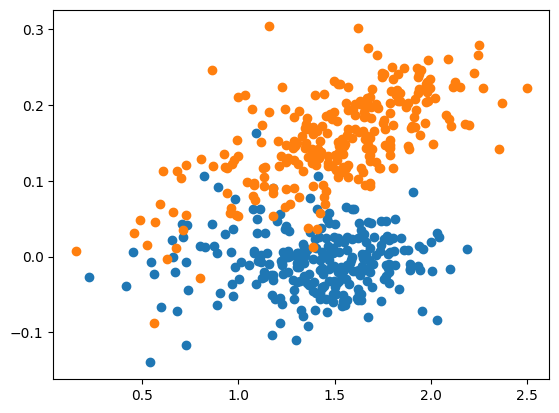

In [7]:
plt.scatter(embeddings_1[:,0], embeddings_1[:,1])
plt.scatter(embeddings_2[:,0], embeddings_2[:,1])

Ok. Even with very good loss, there seem to be failures of linear discriminability, so our LD measurements are probably meaningful.

#### Explore SVM outputs:

In [8]:
from sklearn.svm import SVC
# need to adjust C to get a better classification...
svm = SVC(kernel='linear', C=1.)
svm2 = SVC(kernel='linear', C=1000.)

In [9]:
all_embeddings = torch.concat([embeddings_1, embeddings_2])
labels = torch.concat([torch.zeros(len(embeddings_1)), torch.ones(len(embeddings_2))])

In [10]:
svm.fit(all_embeddings, labels)
svm2.fit(all_embeddings, labels)

SVC(C=1000.0, kernel='linear')

(-0.2, 0.4)

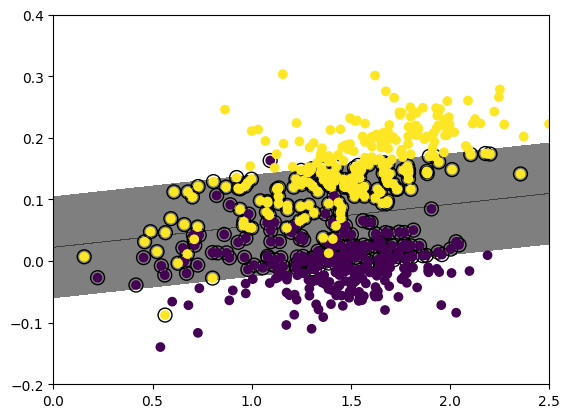

In [11]:
from sklearn.inspection import DecisionBoundaryDisplay
DecisionBoundaryDisplay.from_estimator(
    svm,
    all_embeddings,
    plot_method="contourf",
    colors='k',
    levels=[-1, 0, 1],
    linestyles=["--", "-", "--"],
    alpha=0.5
)

# plot support vectors
plt.scatter(
    svm.support_vectors_[:, 0],
    svm.support_vectors_[:, 1],
    s=100,
    linewidth=1,
    facecolors="none",
    edgecolors="k",
)
plt.scatter(all_embeddings[:,0], all_embeddings[:,1], c=labels)
plt.xlim([0, 2.5])
plt.ylim([-0.2, 0.4])

(-0.2, 0.4)

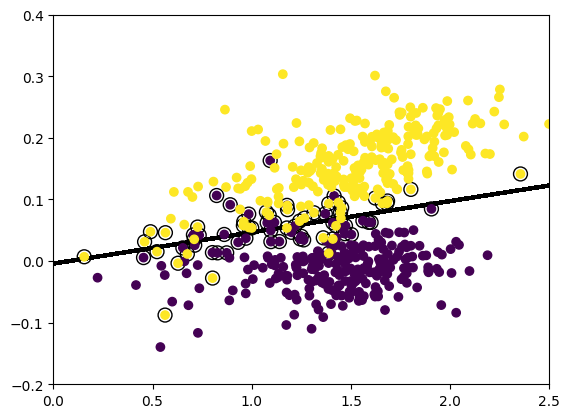

In [24]:
from sklearn.inspection import DecisionBoundaryDisplay
DecisionBoundaryDisplay.from_estimator(
    svm2,
    all_embeddings,
    plot_method="contourf",
    colors='k',
    levels=[-0.1, 0, 0.1],
    linestyles=["--", "-", "--"],
    alpha=1.
)

# plot support vectors
plt.scatter(
    svm2.support_vectors_[:, 0],
    svm2.support_vectors_[:, 1],
    s=100,
    linewidth=1,
    facecolors="none",
    edgecolors="k",
)
plt.scatter(all_embeddings[:,0], all_embeddings[:,1], c=labels)
plt.xlim([0, 2.5])
plt.ylim([-0.2, 0.4])

In [154]:
svm.coef_

array([[-0.21752893, 11.88835401]])

In [145]:
svm2.coef_

array([[-0.96410674, 30.61620863]])

In [136]:
(svm.predict(all_embeddings) != labels.numpy()).sum()

np.int64(34)

In [146]:
(svm2.predict(all_embeddings) != labels.numpy()).sum()

np.int64(29)

### SVM discrimination performance vs separation

In [3]:
from analysis.activity_discrimination import DiscriminationAnalysis
analyzer = DiscriminationAnalysis(model, model.decoder[2])

In [5]:
mus = []
covs = []

deltas = np.logspace(-2,-1, 10)

for i, delta in tqdm(enumerate(deltas)):
    mu, cov = analyzer.get_discrimination_performance(0, delta)
    mus.append(mu)
    covs.append(cov)

10it [10:26, 62.68s/it]


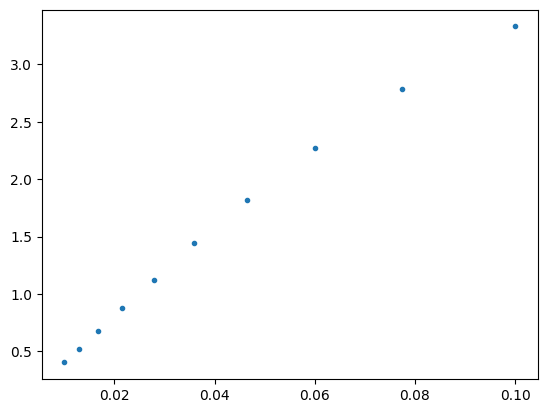

In [6]:
plt.plot(deltas, mus, '.')

In [7]:
np.array(mus) / deltas

array([40.38729953, 40.63118671, 40.86190544, 40.6431028 , 40.42320324,
       40.22735533, 39.17608824, 37.87094708, 35.93548072, 33.31007359])

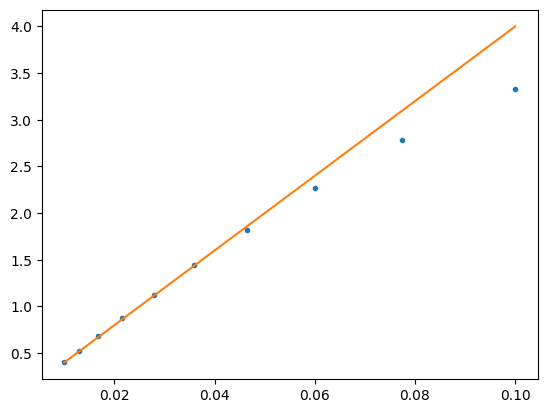

In [8]:
plt.plot(deltas, mus, '.')
plt.plot(deltas, 40 * deltas)

Ok! The discrimination performance scales as expected with the size of the delta difference, falling off a bit at larger angle differences. This looks like a reasonable proxy for the Fisher information.

This is currently very slow. I would like it to be faster, but don't want to invest too much in making that happen.
The bottleneck appears to be loading the data from disk onto the GPU, but that's hard to avoid.

## QA the neural networks from the sweep

#### Also a test of the analysis pipeline.

In [2]:
from data.rotated_faces import RotatedFacesDataset
ds = RotatedFacesDataset()

images, labels = next(iter(torch.utils.data.DataLoader(ds, batch_size=256)))
images = images.to('mps')

def output_magnitude(model):
    model = model.to('mps')
    outs = model.forward(images).detach().cpu()
    return {'mean_norm': outs.norm(dim=1).mean().item(), 'all_norms': outs.norm(dim=1).numpy()}

In [3]:
sweep_dir = '../experiments/multirun/2025-10-21(01:28:54)_loss_sweep'

In [4]:
from analysis.experiment_loader import sweep_analysis

W1021 22:37:03.880000 4790 torch/distributed/elastic/multiprocessing/redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


import error: No module named 'triton'


In [5]:
sweep_analysis(output_magnitude, sweep_dir, './initial_results.parquet')

/Users/luke/.local/defaultPythonEnv/lib/python3.12/site-packages/pytorch_lightning/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.5.5, which is newer than your current Lightning version: v2.4.0


In [6]:
data = pd.read_parquet('initial_results.parquet')

In [9]:
data

,kappa,loss,mean_norm,all_norms
0,10.00,sqrt_diff,0.423991,"[0.57643914, 0.53426576, 0.12707761, 0.4003351..."
1,10.00,sq_diff,0.399066,"[0.5286979, 0.46229392, 0.13105518, 0.32981893..."
2,10.00,angle_diff,0.443326,"[0.62079006, 0.6144408, 0.06551388, 0.40563923..."
3,0.01,sqrt_diff,20.748369,"[0.52212995, 0.479492, 0.0632902, 0.21846716, ..."
4,1.00,sq_diff,27.105579,"[0.47312716, 0.6416268, 0.37317872, 0.3390638,..."
5,0.01,sq_diff,21.209770,"[0.42178488, 0.5554137, 0.19695781, 0.28315154..."
6,1.00,angle_diff,31.162781,"[0.5246804, 0.6996194, 0.15901498, 0.30657947,..."
7,1.00,sqrt_diff,29.200901,"[0.48407066, 0.5981412, 0.03984237, 0.23391728..."
8,0.01,angle_diff,24.629366,"[0.46276945, 0.46681595, 0.15621491, 0.1868391..."


<Axes: xlabel='kappa', ylabel='mean_norm'>

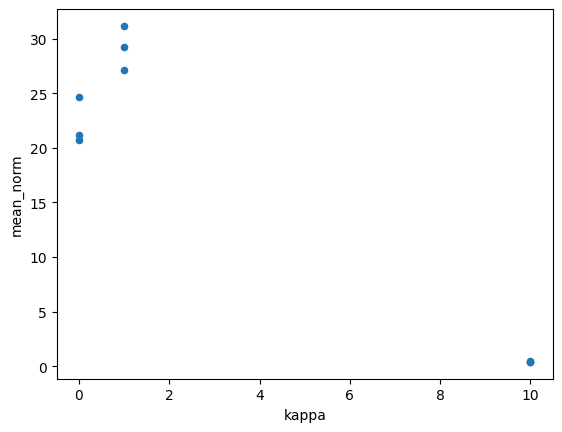

In [10]:
data.plot.scatter(x='kappa', y='mean_norm')

Looks good: the square-root networks seem to be ok, even though they often went to nan during training. Probably not the 'best' performance. Interestingly, large kappa  (more concentrated) gives lower output norms. Less concentrated has more variable output norms

## Fisher information in the networks from the sweep

In [2]:
from analysis.activity_discrimination import DiscriminationAnalysis
from analysis.experiment_loader import sweep_analysis

W1022 01:30:47.090000 6911 torch/distributed/elastic/multiprocessing/redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


import error: No module named 'triton'


In [3]:
def FisherCurves(model):
    model = model.to('mps')
    analyzer = DiscriminationAnalysis(model, model.decoder[2])

    angles = np.linspace(-np.pi, np.pi, 50)
    FI = analyzer.Fisher_info(angles)
    
    return {'fisher_curve': FI}

In [4]:
sweep_dir = '../experiments/multirun/2025-10-21(01:28:54)_loss_sweep'
sweep_analysis(FisherCurves, sweep_dir, './fisher_curves.parquet')

0it [00:00, ?it/s]/Users/luke/.local/defaultPythonEnv/lib/python3.12/site-packages/pytorch_lightning/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.5.5, which is newer than your current Lightning version: v2.4.0

100%|███████████████████████████████████████████| 50/50 [52:53<00:00, 63.46s/it]
1it [52:53, 3173.81s/it]/Users/luke/.local/defaultPythonEnv/lib/python3.12/site-packages/pytorch_lightning/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.5.5, which is newer than your current Lightning version: v2.4.0

100%|███████████████████████████████████████████| 50/50 [52:04<00:00, 62.49s/it]
2it [1:44:58, 3145.04s/it]/Users/luke/.local/defaultPythonEnv/lib/python3.12/site-packages/pytorch_lightning/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.5.5, which is newer than your current Lightning version: v2.4.0

100%|███████████████████████████████████████████| 50/50 [52:00<00:00

In [25]:
all_fisher = pd.read_parquet('fisher_curves.parquet')
angles = np.linspace(-np.pi, np.pi, 50)

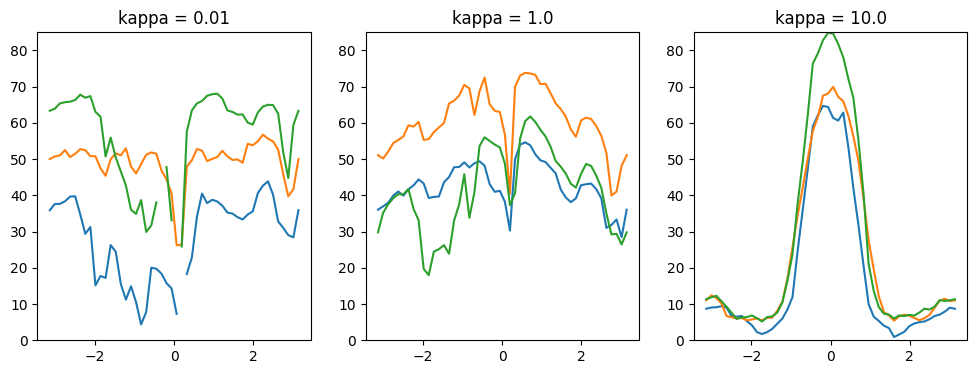

In [26]:
figsize(12,4)
plt.subplots(1,3)
for i, kappa in enumerate(sorted(all_fisher.kappa.unique())):
    plt.subplot(1,3,i+1)
    plt.title(f'kappa = {kappa}')
    plt.ylim([0, 85])
    for row in all_fisher[all_fisher.kappa == kappa].iterrows():
        plt.plot(angles, row[1]['fisher_curve'])


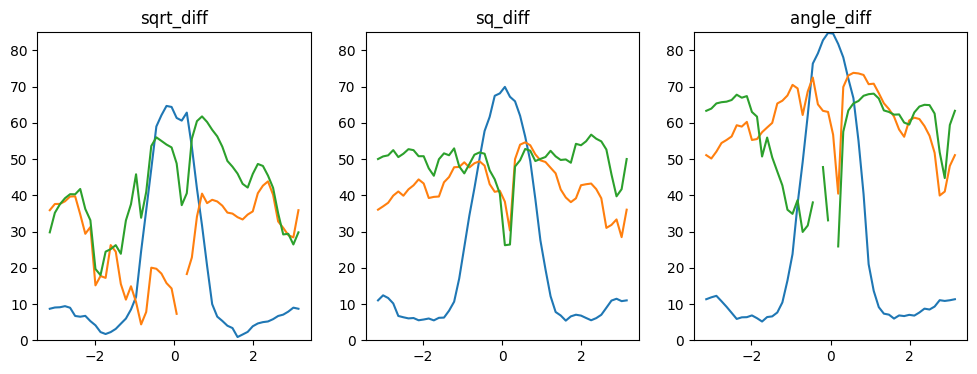

In [27]:
figsize(12,4)
plt.subplots(1,3)
for i, loss in enumerate(all_fisher.loss.unique()):
    plt.subplot(1,3,i+1)
    plt.title(loss)
    plt.ylim([0, 85])
    for row in all_fisher[all_fisher.loss == loss].iterrows():
        plt.plot(angles, row[1]['fisher_curve'])

Interesting. The very concentrated distributions behave as expected. The less concentrated distributions have substantially more variable Fisher information. 

Is this 'real' or is it an artifact of the Fisher information measurement approach? The nan values seem to indicate a breakdown in my Fisher information measurements. Also, we do see that too large of separations lead to _sublinear_ FI measurements, meaning that under-estimation is to be expected.

The sharp downturns in the Fisher information near zero are an interesting feature that needs more investigation.

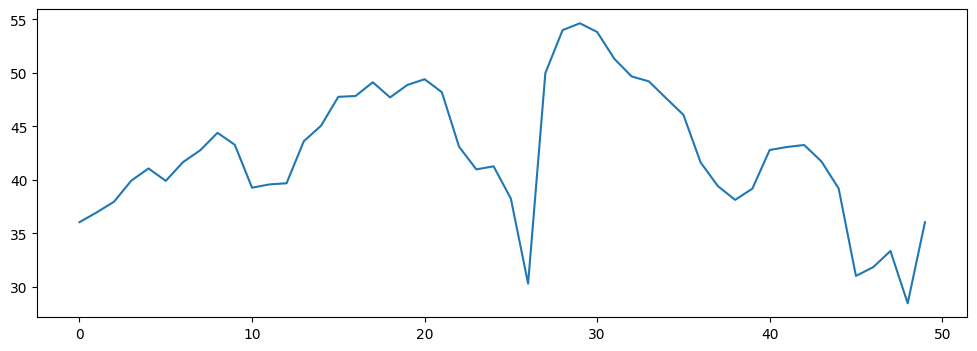

In [28]:
plt.plot(all_fisher.loc[4].fisher_curve)

In [29]:
from models.face_angle import EstimateAngle
from data.rotated_faces import ConsistentRotationDataset, RotatedFacesDataset
from analysis.activity_discrimination import DiscriminationAnalysis

model_dir = '../experiments/multirun/2025-10-21(01:28:54)_loss_sweep/4_kappa_1.0_loss_sq_diff/checkpoints/best.ckpt'
model = EstimateAngle.load_from_checkpoint(model_dir)
model = model.to('mps')

analyzer = DiscriminationAnalysis(model, model.decoder[2])


/Users/luke/.local/defaultPythonEnv/lib/python3.12/site-packages/pytorch_lightning/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.5.5, which is newer than your current Lightning version: v2.4.0


In [30]:
np.where(all_fisher.loc[4, 'fisher_curve'] < 31)

(array([26, 48]),)

In [31]:
angles[26]

np.float64(0.19234240736264008)

#### Reproduces the FI measurements

In [32]:
analyzer.get_discrimination_performance(angles[26], 0.03)[0] / 0.03

np.float64(30.29892194211599)

In [21]:
analyzer.get_discrimination_performance(angles[29], 0.03)[0] / 0.03

np.float64(54.6275735652593)

#### Investigate the representation

In [33]:
data, labels = analyzer.get_activity(angles[26], 0.03)

(-0.25, 0.25)

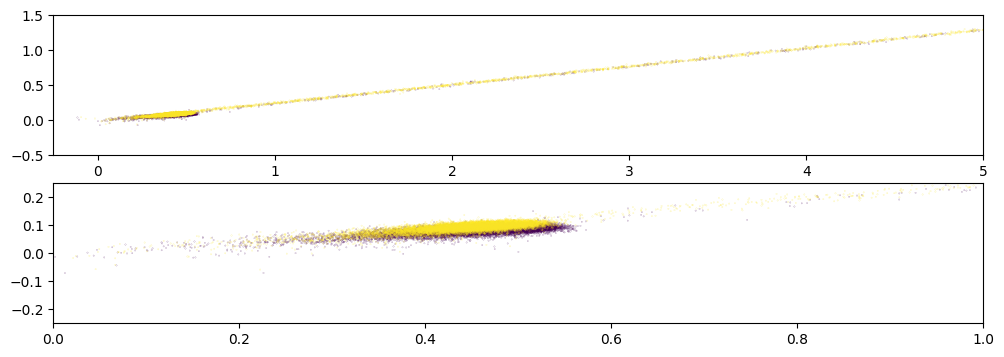

In [34]:
plt.subplots(2,1)
plt.subplot(2,1,1)
plt.scatter(data[:,0], data[:,1], c=labels, s=0.01)
plt.xlim([-0.25,5])
plt.ylim([-0.5,1.5])

plt.subplot(2,1,2)
plt.scatter(data[:,0], data[:,1], c=labels, s=0.01)
plt.xlim([0,1])
plt.ylim([-0.25,0.25])

Notably, there is a large 'tail' of data that is hard to discriminate, but may throw off the SVM.

In [28]:
from sklearn.svm import SVC
svm = SVC(kernel='linear', C=1.)
svm.fit(data, labels)

SVC(kernel='linear')

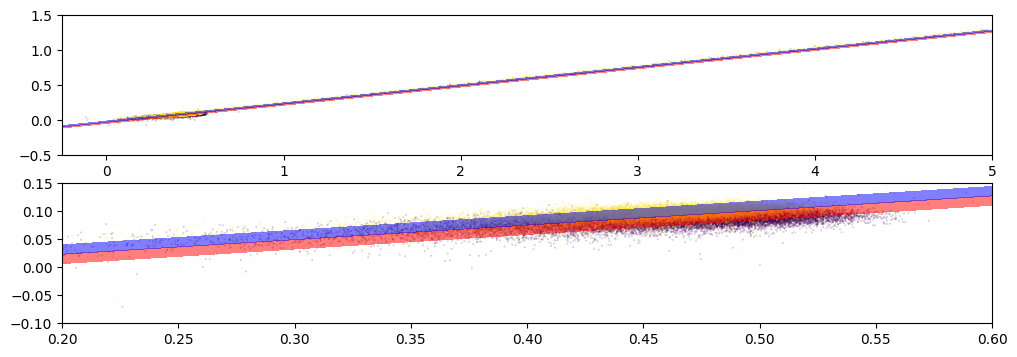

In [39]:
from sklearn.inspection import DecisionBoundaryDisplay

plt.subplots(2,1)
ax = plt.subplot(2,1,1)
plt.scatter(data[:,0], data[:,1], c=labels, s=0.01)
DecisionBoundaryDisplay.from_estimator(
    svm,
    data,
    plot_method="contourf",
    colors=['r', 'b'],
    levels=[-1, 0, 1],
    linestyles=["--", "-", "--"],
    alpha=0.5,
    ax=ax
)
plt.xlim([-0.25,5])
plt.ylim([-0.5,1.5])

ax=plt.subplot(2,1,2)
plt.scatter(data[:,0], data[:,1], c=labels, s=0.01)
DecisionBoundaryDisplay.from_estimator(
    svm,
    data,
    plot_method="contourf",
    colors=['r', 'b'],
    levels=[-1, 0, 1],
    linestyles=["--", "-", "--"],
    alpha=0.5,
    ax=ax
)
plt.xlim([0.2,0.6])
_=plt.ylim([-0.1,0.15])


Here we can see why the FI is so low: the SVM decision boundary is mostly fitting on the tail of the data, not the core of the data. This leads to a lot of misclassifications

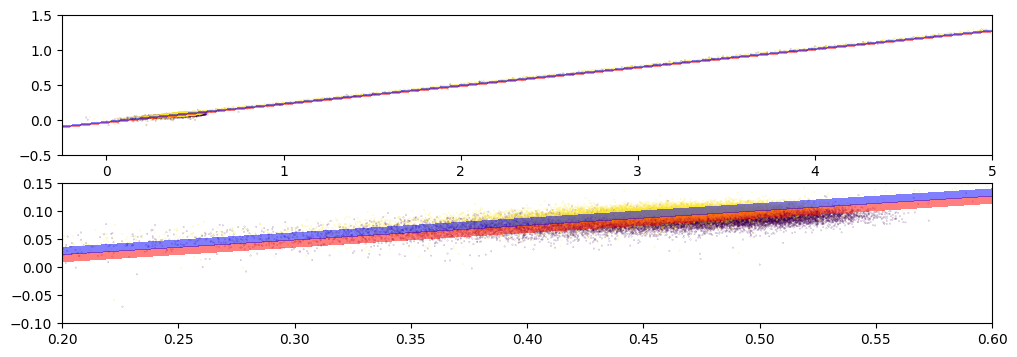

In [40]:
from sklearn.svm import SVC
svm = SVC(kernel='linear', C=1000.)
svm.fit(data, labels)

from sklearn.inspection import DecisionBoundaryDisplay

plt.subplots(2,1)
ax = plt.subplot(2,1,1)
plt.scatter(data[:,0], data[:,1], c=labels, s=0.01)
DecisionBoundaryDisplay.from_estimator(
    svm,
    data,
    plot_method="contourf",
    colors=['r', 'b'],
    levels=[-1, 0, 1],
    linestyles=["--", "-", "--"],
    alpha=0.5,
    ax=ax
)
plt.xlim([-0.25,5])
plt.ylim([-0.5,1.5])

ax=plt.subplot(2,1,2)
plt.scatter(data[:,0], data[:,1], c=labels, s=0.01)
DecisionBoundaryDisplay.from_estimator(
    svm,
    data,
    plot_method="contourf",
    colors=['r', 'b'],
    levels=[-1, 0, 1],
    linestyles=["--", "-", "--"],
    alpha=0.5,
    ax=ax
)
plt.xlim([0.2,0.6])
_=plt.ylim([-0.1,0.15])

In [52]:
(svm.predict(data) == labels).sum() / len(data)

tensor(0.7669)

This is a fairly low accuracy compared to previously.

In [53]:
mus = []
covs = []

deltas = np.logspace(-2,-1, 10)

for i, delta in tqdm(enumerate(deltas)):
    mu, cov = analyzer.get_discrimination_performance(0, delta)
    mus.append(mu)
    covs.append(cov)

10it [12:46, 76.62s/it]


In [54]:
covs

[array(0.01845967),
 array(0.01163126),
 array(0.0291457),
 array(0.08946734),
 array(0.20078644),
 array(0.24912129),
 array(0.15324279),
 array(0.00995893),
 array(0.00105819),
 array(0.00084211)]

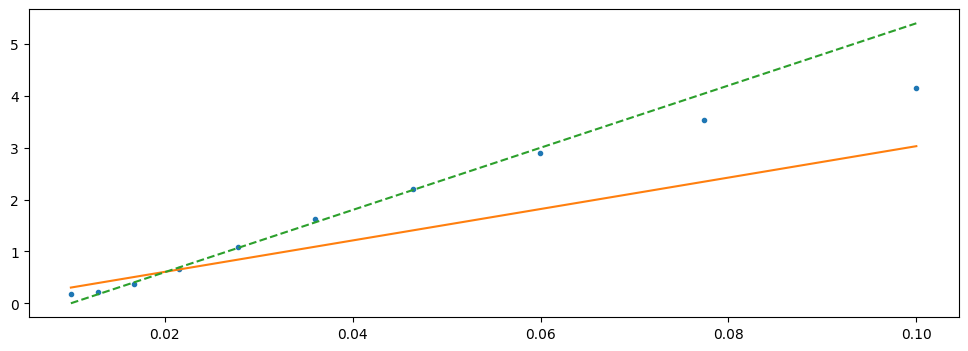

In [67]:
plt.plot(deltas, mus, '.')
plt.plot(deltas, all_fisher.loc[4].fisher_curve[26]*deltas)
plt.plot(deltas, 60*deltas - 30*0.02, '--')

Note:
1. Large cv covariances in the middle points.
2. The single-point Fisher information does look too low.

#### Trying out various robust approaches to the analysis.

In [56]:
from sklearn.preprocessing import RobustScaler
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_classification

In [57]:
robust_svm = make_pipeline(RobustScaler(), SVC(kernel='linear', C=1.0))
robust_svm.fit(data, labels)

Pipeline(steps=[('robustscaler', RobustScaler()),
                ('svc', SVC(kernel='linear'))])

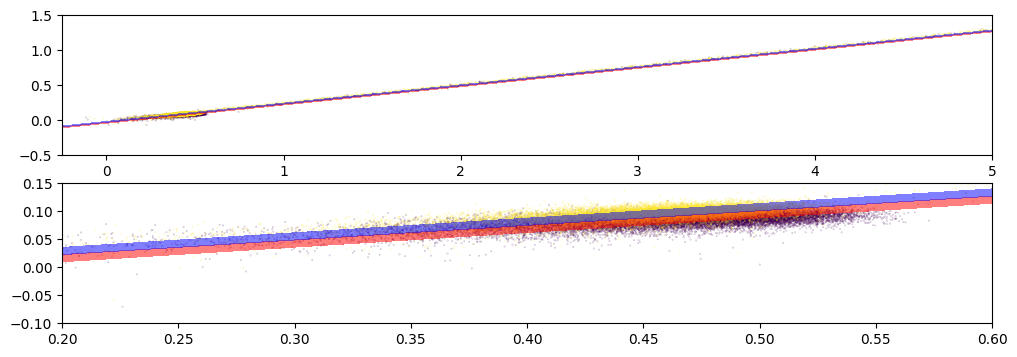

In [58]:
plt.subplots(2,1)
ax = plt.subplot(2,1,1)
plt.scatter(data[:,0], data[:,1], c=labels, s=0.01)
DecisionBoundaryDisplay.from_estimator(
    robust_svm,
    data,
    plot_method="contourf",
    colors=['r', 'b'],
    levels=[-1, 0, 1],
    linestyles=["--", "-", "--"],
    alpha=0.5,
    ax=ax
)
plt.xlim([-0.25,5])
plt.ylim([-0.5,1.5])

ax=plt.subplot(2,1,2)
plt.scatter(data[:,0], data[:,1], c=labels, s=0.01)
DecisionBoundaryDisplay.from_estimator(
    robust_svm,
    data,
    plot_method="contourf",
    colors=['r', 'b'],
    levels=[-1, 0, 1],
    linestyles=["--", "-", "--"],
    alpha=0.5,
    ax=ax
)
plt.xlim([0.2,0.6])
_=plt.ylim([-0.1,0.15])

In [68]:
(robust_svm.predict(data) == labels).sum() / len(data)

tensor(0.7669)

Maybe better, but still not great

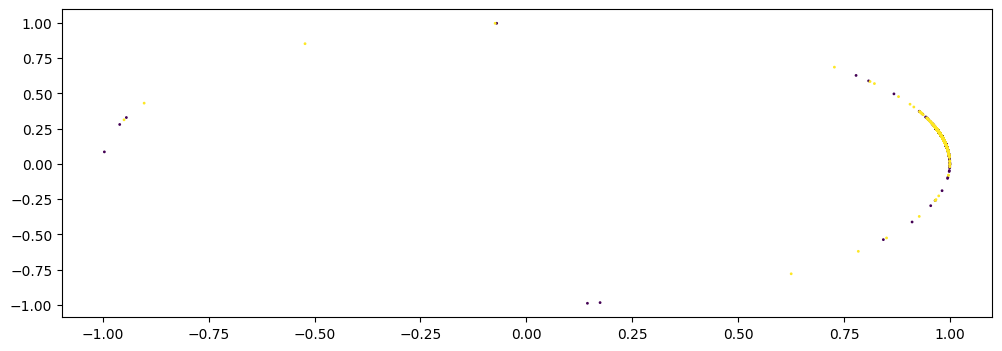

In [81]:
normed = data / data.norm(dim=1)[:,None]
plt.scatter(normed[:,0], normed[:,1], c=labels, s=1)

In [78]:
svm = SVC(kernel='linear', C=1.)
svm.fit(normed, labels)

SVC(kernel='linear')

In [80]:
(svm.predict(normed) == labels).sum() / len(normed)

tensor(0.7761)

In [89]:
data_outlier_removed = data[data.norm(dim=1) < 1]
labels_outlier_removed = labels[data.norm(dim=1) < 1]

svm_outlier_removed = SVC(kernel='linear', C=1.)
svm_outlier_removed.fit(data_outlier_removed, labels_outlier_removed)

SVC(kernel='linear')

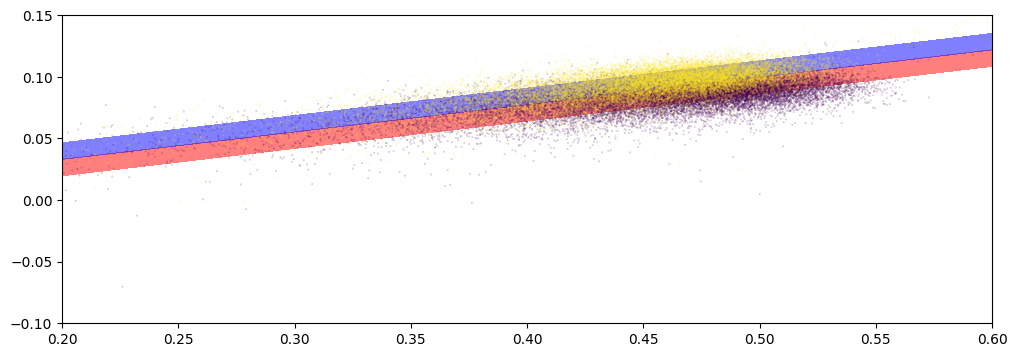

In [95]:
DecisionBoundaryDisplay.from_estimator(
    svm_outlier_removed,
    data,
    plot_method="contourf",
    colors=['r', 'b'],
    levels=[-1, 0, 1],
    linestyles=["--", "-", "--"],
    alpha=0.5
)
plt.scatter(data_outlier_removed[:,0], data_outlier_removed[:,1], c=labels_outlier_removed, s=0.01)
plt.xlim([0.2,0.6])
_=plt.ylim([-0.1,0.15])

In [93]:
from analysis.activity_discrimination import dprime

In [98]:
dprime(data_outlier_removed, labels_outlier_removed, data_outlier_removed, labels_outlier_removed) / 0.03

np.float64(48.55409471526834)

Brute force outlier removal does force better (although still not visually correct) discriminations, higher Fisher info outputs. How to get more robust statistics?

#### Continued

In [47]:
data, labels = analyzer.get_activity(angles[26], 0.03)
data_outlier_removed = data[data.norm(dim=1) < 1]
labels_outlier_removed = labels[data.norm(dim=1) < 1]

(-0.25, 0.25)

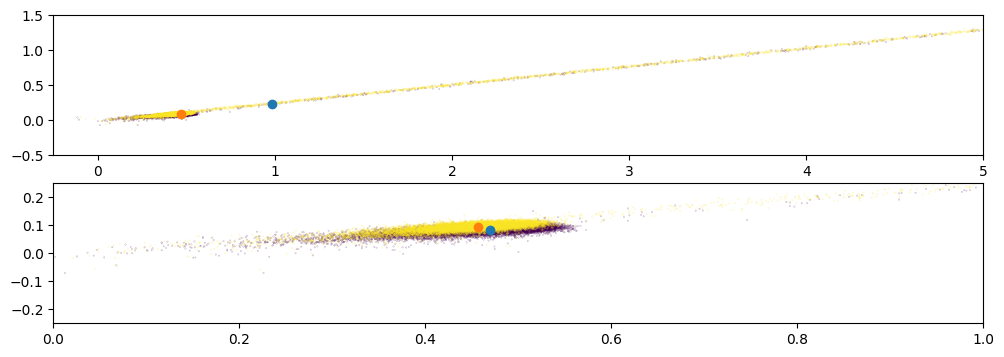

In [63]:
plt.subplots(2,1)
plt.subplot(2,1,1)
plt.scatter(data[:,0], data[:,1], c=labels, s=0.01)
plt.scatter(data.mean(0)[0], data.mean(0)[1])
plt.scatter(data.median(0).values[0], data.median(0).values[1])
plt.xlim([-0.25,5])
plt.ylim([-0.5,1.5])

from sklearn.covariance import MinCovDet
mcd0 = MinCovDet().fit(data[labels==0])
mu_robust0 = mcd0.location_
cov_robust0 = mcd0.covariance_

mcd1 = MinCovDet().fit(data[labels==1])
mu_robust1 = mcd1.location_
cov_robust1 = mcd1.covariance_

plt.subplot(2,1,2)
plt.scatter(data[:,0], data[:,1], c=labels, s=0.01)
plt.scatter(mu_robust0[0], mu_robust0[1])
plt.scatter(mu_robust1[0], mu_robust1[1])
plt.xlim([0,1])
plt.ylim([-0.25,0.25])

(-0.05, 0.15)

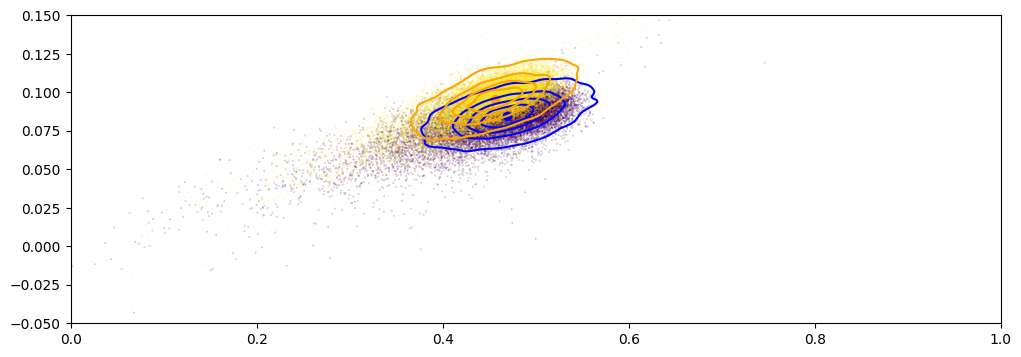

In [67]:
plt.scatter(data[:,0], data[:,1], c=labels, s=0.01)
plt.scatter(mu_robust0[0], mu_robust0[1], color='blue')
x, y = np.random.multivariate_normal(mu_robust0, cov_robust0, 10000).T
sns.kdeplot(x=x, y=y, levels=5, color="blue", linewidths=1.5)

plt.scatter(mu_robust1[0], mu_robust1[1], color='orange')
x, y = np.random.multivariate_normal(mu_robust1, cov_robust1, 10000).T
sns.kdeplot(x=x, y=y, levels=5, color="orange", linewidths=1.5)

plt.xlim([0,1])
plt.ylim([-0.05,0.15])

I mean, the robust fits actually look pretty good.

In [68]:
from scipy.spatial.distance import mahalanobis

In [71]:
mahalanobis(mu_robust0, mu_robust1, np.linalg.inv(cov_robust0))

np.float64(1.5546691223268867)

In [81]:
mahalanobis(mu_robust0, mu_robust1, np.linalg.inv(cov_robust1))

np.float64(1.5964710928494676)

In [111]:
mahalanobis(mu_robust0, mu_robust1, np.linalg.inv(0.5*cov_robust1 + 0.5*cov_robust0)) / 0.03

np.float64(52.17169987758096)

### Check the scaling of robust fits with separation.

In [121]:
from sklearn.covariance import MinCovDet
from scipy.spatial.distance import mahalanobis

def robust_FI(analyzer, center, delta):
    data, labels = analyzer.get_activity(center, delta)

    mcd0 = MinCovDet().fit(data[labels==0])
    mu_robust0 = mcd0.location_
    cov_robust0 = mcd0.covariance_
    
    mcd1 = MinCovDet().fit(data[labels==1])
    mu_robust1 = mcd1.location_
    cov_robust1 = mcd1.covariance_

    return mahalanobis(mu_robust0, mu_robust1, np.linalg.inv(0.5*cov_robust1 + 0.5*cov_robust0)) / delta

In [124]:
robust_FI(analyzer, 0., 0.03)

np.float64(60.549190246734405)

In [127]:
FIs = []

deltas = np.logspace(-2,-1, 10)

for delta in tqdm(deltas):
    FI = robust_FI(analyzer, 0., delta)
    print(FI)
    FIs.append(FI)

 10%|████▍                                       | 1/10 [00:57<08:37, 57.45s/it]

67.19781971612882


 20%|████████▊                                   | 2/10 [01:57<07:52, 59.08s/it]

58.643106130026645


 30%|█████████████▏                              | 3/10 [02:57<06:57, 59.58s/it]

59.33530911405567


 40%|█████████████████▌                          | 4/10 [03:54<05:50, 58.39s/it]

59.89482285669314


 50%|██████████████████████                      | 5/10 [04:50<04:47, 57.54s/it]

60.437187705674084


 60%|██████████████████████████▍                 | 6/10 [05:45<03:46, 56.56s/it]

60.537929599493964


 70%|██████████████████████████████▊             | 7/10 [06:40<02:48, 56.10s/it]

60.22128742153185


 80%|███████████████████████████████████▏        | 8/10 [07:35<01:51, 55.84s/it]

60.07455293079966


 90%|███████████████████████████████████████▌    | 9/10 [08:29<00:55, 55.31s/it]

59.72021199878151


100%|███████████████████████████████████████████| 10/10 [09:24<00:00, 56.45s/it]

59.61141446001912


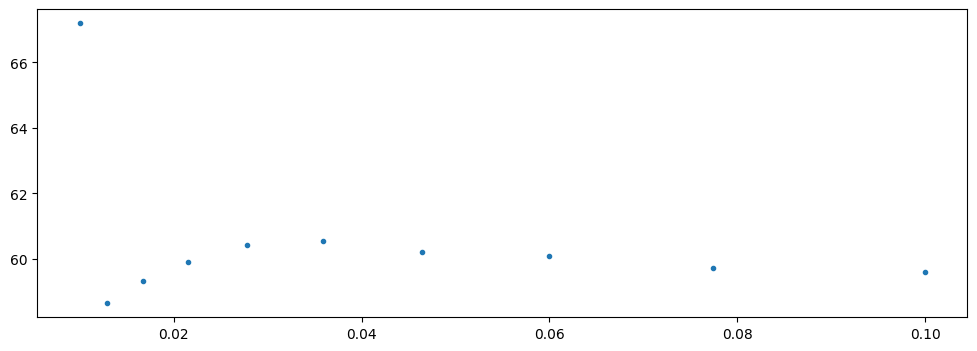

In [130]:
plt.plot(deltas, np.array(FIs), '.')

Robust Fisher information measurements seem relatively stable. I'll just stick to my 0.03 separation for now.

### Robust Fisher Information results

In [2]:
from sklearn.covariance import MinCovDet
from scipy.spatial.distance import mahalanobis

from pathlib import Path
def robust_FI(data, labels, delta):
    mcd0 = MinCovDet().fit(data[labels == 0])
    mu_robust0 = mcd0.location_
    cov_robust0 = mcd0.covariance_
    
    mcd1 = MinCovDet().fit(data[labels == 1])
    mu_robust1 = mcd1.location_
    cov_robust1 = mcd1.covariance_

    return mahalanobis(mu_robust0, mu_robust1,
                       np.linalg.inv(0.5*cov_robust1 + 0.5*cov_robust0)
                       ) / delta


def evaluate_Fisher_curves(kappa, loss, accumulator):
    delta = 0.03

    FIs = []
    for i in tqdm(range(50)):
        path = Path(f'../experiment_data/activity/{kappa}/{loss}/{i}')
        data = torch.load(path / 'data.pt')
        labels = torch.load(path / 'labels.pt')
        FIs.append(robust_FI(data,labels, 0.03))

    row = {'kappa': kappa,
           'loss': loss,
           'fisher_info': np.array(FIs)}

    accumulator.append(row)
    
    return np.array( FIs)

In [25]:
angles = np.linspace(-np.pi, np.pi, 50)
FIs = []
for kappa in [0.01, 1.0, 10.0]:
    for loss in ['angle_diff', 'sq_diff', 'sqrt_diff']:
        _ = evaluate_Fisher_curves(kappa, loss, FIs)

FIs = pd.DataFrame(FIs)

100%|███████████████████████████████████████████| 50/50 [02:41<00:00,  3.23s/it]


In [26]:
FIs

,kappa,loss,fisher_info
0,0.01,angle_diff,"[72.38007785469348, 71.96499336718948, 73.9203..."
1,0.01,sq_diff,"[54.05461579595915, 54.697662171803536, 55.594..."
2,0.01,sqrt_diff,"[38.687180738167946, 40.441518728150534, 41.02..."
3,1.00,angle_diff,"[56.37606821812646, 54.73044915021474, 56.8704..."
4,1.00,sq_diff,"[38.34704214480824, 39.59039140440722, 40.9760..."
5,1.00,sqrt_diff,"[33.87122530837991, 38.423194608952976, 41.273..."
6,10.00,angle_diff,"[12.579524657909708, 13.272296251649323, 13.37..."
7,10.00,sq_diff,"[11.666357484754403, 12.900214606781542, 12.70..."
8,10.00,sqrt_diff,"[9.191549381793767, 9.187036746819777, 9.44771..."


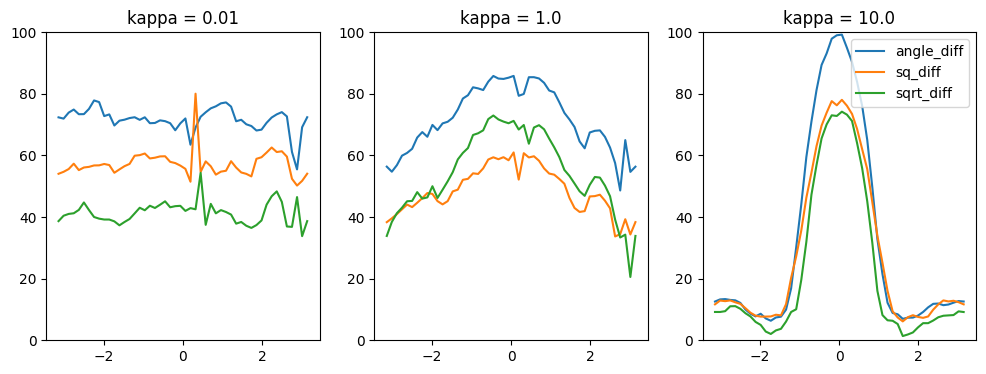

In [46]:
figsize(12,4)

color_dict = {loss: f'C{i}' for i, loss in enumerate(['angle_diff', 'sq_diff', 'sqrt_diff'])}
plt.subplots(1,3)
for i, kappa in enumerate(sorted(FIs.kappa.unique())):
    plt.subplot(1,3,i+1)
    plt.title(f'kappa = {kappa}')
    plt.ylim([0, 100])
    for i, row in FIs[FIs.kappa == kappa].iterrows():
        plt.plot(angles, row['fisher_info'], color=color_dict[row['loss']], label=row['loss'])

plt.legend()

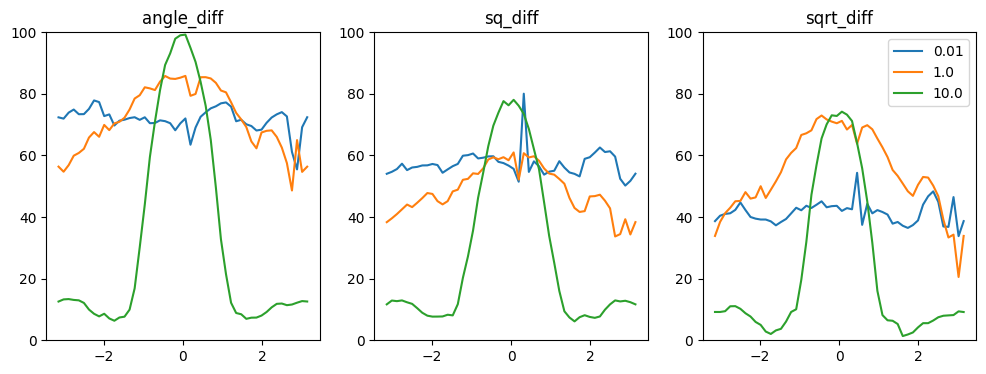

In [47]:
figsize(12,4)
plt.subplots(1,3)

color_dict = {str(kappa): f'C{i}' for i, kappa in enumerate([0.01, 1.0, 10.0])}
for i, loss in enumerate(FIs.loss.unique()):
    plt.subplot(1,3,i+1)
    plt.title(loss)
    plt.ylim([0, 100])
    for i, row in FIs[FIs.loss == loss].iterrows():
        plt.plot(angles, row['fisher_info'], color=color_dict[str(row['kappa'])], label=row['kappa'])

plt.legend()

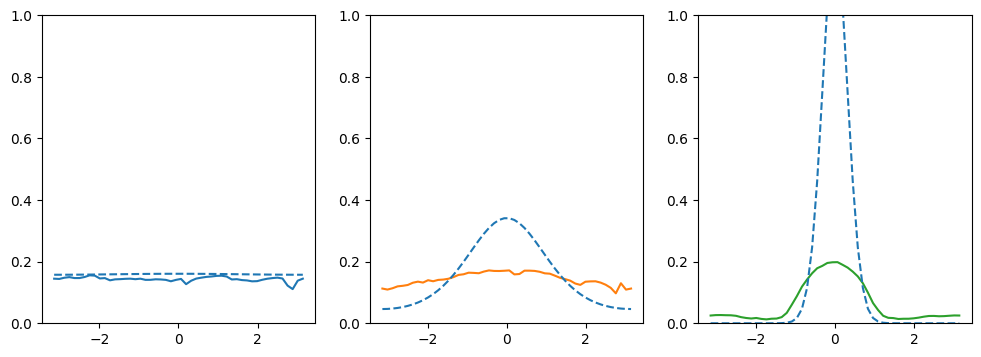

In [64]:
from scipy.stats import vonmises
figsize(12,4)
plt.subplots(1,3)

plt.ylim([0, 100])
for i, row in enumerate(FIs[FIs.loss == 'angle_diff' ].sort_values('kappa').iterrows()):
    row = row[1]
    plt.subplot(1,3,i+1)
    plt.plot(angles, row['fisher_info']/500 , color=color_dict[str(row['kappa'])], label=row['kappa'])

    dist = vonmises(loc=0, kappa=row['kappa'])
    plt.plot(angles, dist.pdf(angles), '--')
    plt.ylim([0,1])


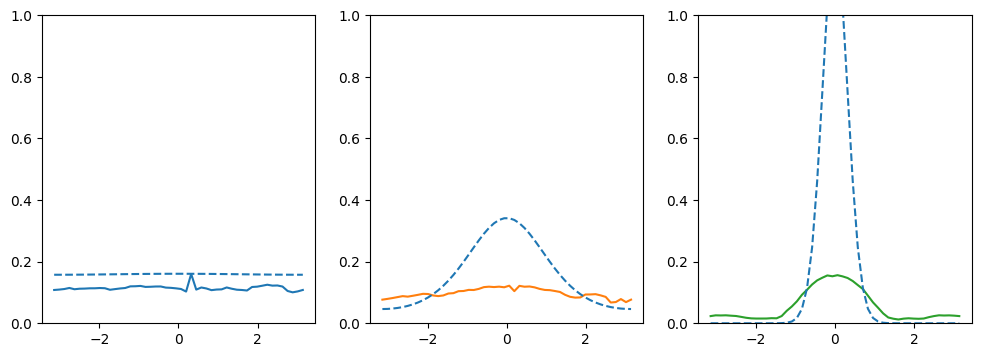

In [65]:
from scipy.stats import vonmises
figsize(12,4)
plt.subplots(1,3)

plt.ylim([0, 100])
for i, row in enumerate(FIs[FIs.loss == 'sq_diff' ].sort_values('kappa').iterrows()):
    row = row[1]
    plt.subplot(1,3,i+1)
    plt.plot(angles, row['fisher_info']/500 , color=color_dict[str(row['kappa'])], label=row['kappa'])

    dist = vonmises(loc=0, kappa=row['kappa'])
    plt.plot(angles, dist.pdf(angles), '--')
    plt.ylim([0,1])


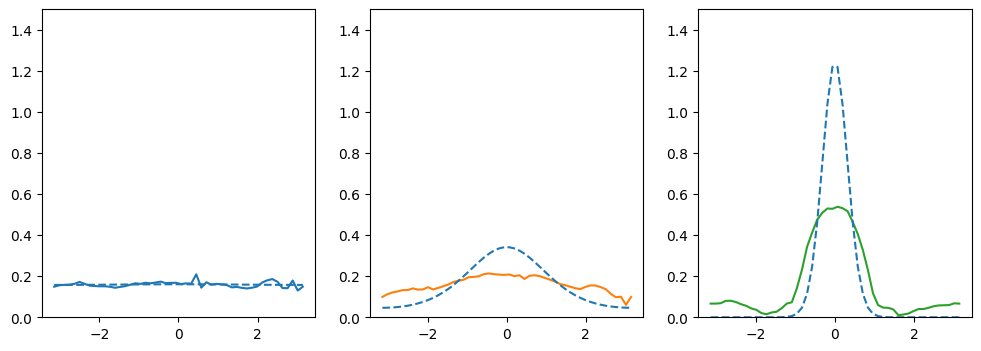

In [72]:
from scipy.stats import vonmises
figsize(12,4)
plt.subplots(1,3)

plt.ylim([0, 100])
for i, row in enumerate(FIs[FIs.loss == 'sqrt_diff' ].sort_values('kappa').iterrows()):
    row = row[1]
    plt.subplot(1,3,i+1)
    plt.plot(angles, row['fisher_info']/(row['fisher_info'].sum()*np.pi/25) , color=color_dict[str(row['kappa'])], label=row['kappa'])

    dist = vonmises(loc=0, kappa=row['kappa'])
    plt.plot(angles, dist.pdf(angles), '--')
    plt.ylim([0,1.5])

These look like great demo figures.

In [75]:
FIs.to_parquet('robust_fisher.parquet')

### Fisher information for 'constrained' networks.

In [3]:
def evaluate_Fisher_curves_constraint(kappa, accumulator):
    delta = 0.03

    FIs = []
    for i in tqdm(range(50)):
        path = Path(f'../experiment_data/activity_constraint/{kappa}/angle_diff/{i}')
        data = torch.load(path / 'data.pt')
        labels = torch.load(path / 'labels.pt')
        FIs.append(robust_FI(data,labels, 0.03))

    row = {'kappa': kappa,
           'fisher_info': np.array(FIs)}

    accumulator.append(row)
    
    return np.array( FIs)

angles = np.linspace(-np.pi, np.pi, 50)
FIs = []
for kappa in [0.01, 1.0, 10.0]:
    _ = evaluate_Fisher_curves_constraint(kappa, FIs)

FIs = pd.DataFrame(FIs)

100%|███████████████████████████████████████████| 50/50 [02:40<00:00,  3.21s/it]


In [4]:
FIs

,kappa,fisher_info
0,0.01,"[7.14195405543355, 6.928461116408983, 8.929529..."
1,1.00,"[7.428990753029835, 7.825611935773727, 8.96833..."
2,10.00,"[6.6672130264275715, 5.837905699332505, 7.9249..."


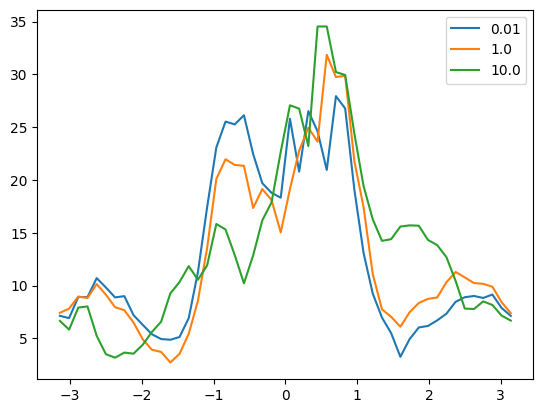

In [13]:
for i, row in FIs.iterrows():
    plt.plot(angles, row['fisher_info'], label=row['kappa'])

plt.legend()

In [52]:
FIs_constraint = pd.read_parquet('constraint_fisher.parquet')

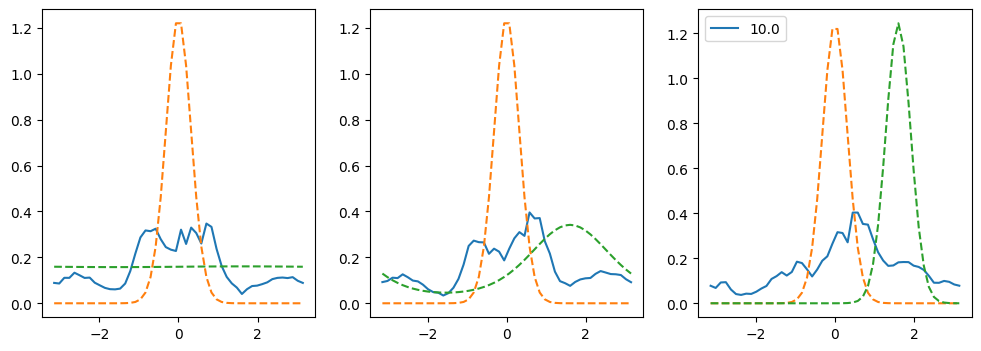

In [54]:
from scipy.stats import vonmises
def normalized_FI(FIs, delta=np.pi/25):
    return FIs / (FIs.sum() * delta)

figsize(12,4)
plt.subplots(1,3)
for i, row in FIs_constraint.iterrows():
    plt.subplot(1,3,i+1)
    plt.plot(angles, normalized_FI(row['fisher_info']), label=row['kappa'])

    dist_old = vonmises(loc=0, kappa=10)
    dist_new = vonmises(loc=1.6, kappa=row['kappa'])
    plt.plot(angles, dist_old.pdf(angles), '--')
    plt.plot(angles, dist_new.pdf(angles), '--')

plt.legend()

Equivalent probability density:

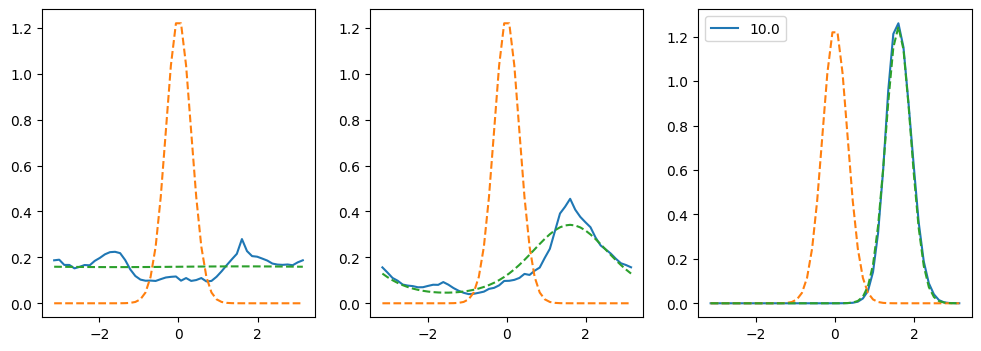

In [56]:
from scipy.stats import vonmises
def normalized_FI(FIs, delta=np.pi/25):
    return FIs / (FIs.sum() * delta)

figsize(12,4)
plt.subplots(1,3)
for i, row in FIs_constraint.iterrows():
    plt.subplot(1,3,i+1)

    dist_old = vonmises(loc=0, kappa=10)
    dist_new = vonmises(loc=1.6, kappa=row['kappa'])

    prob_s = dist_new.pdf(angles)
    FIs = row['fisher_info']
    prob_theta = prob_s / (FIs / FIs.sum())**0.5
    prob_theta = prob_theta / (prob_theta.sum()*np.pi/25)
    

    plt.plot(angles, prob_theta, label=row['kappa'])


    plt.plot(angles, dist_old.pdf(angles), '--')
    plt.plot(angles, dist_new.pdf(angles), '--')

plt.legend()

### Equivalent probability

In [38]:
FI_data = pd.read_parquet('robust_fisher.parquet')

<>:22: SyntaxWarning: invalid escape sequence '\s'
<>:22: SyntaxWarning: invalid escape sequence '\s'
/var/folders/_j/lst7wc811v14243bptx2xw640000gn/T/ipykernel_64735/2189109223.py:22: SyntaxWarning: invalid escape sequence '\s'
  plt.title('$\sigma^{-1}$ = ' + f'{row['kappa']}', fontsize=16)


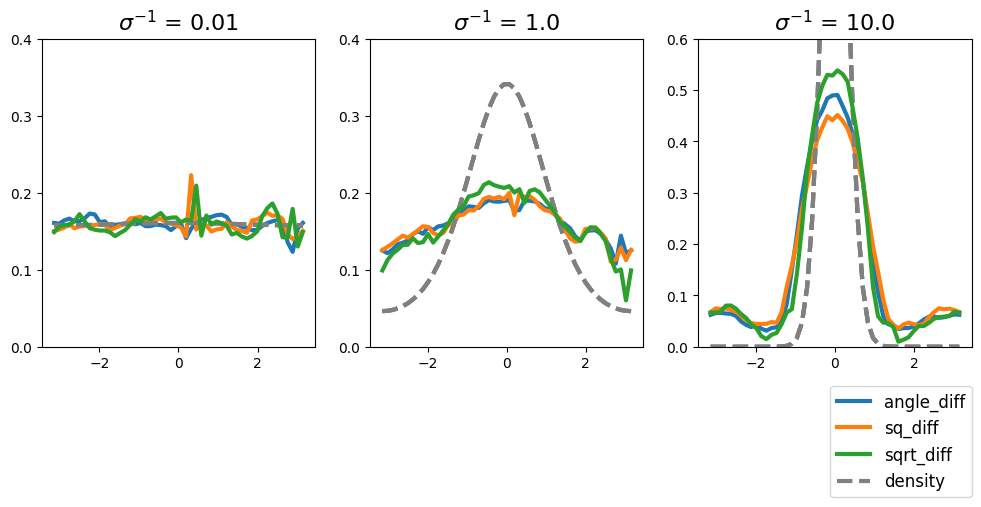

In [39]:
figsize(12,4)
plt.subplots(1,3)

color_dict = {loss: f'C{i}' for i, loss in enumerate(['angle_diff', 'sq_diff', 'sqrt_diff'])}
plt.ylim([0, 100])

for loss in ['angle_diff', 'sq_diff', 'sqrt_diff']:
    for i, row in enumerate(FI_data[FI_data.loss == loss ].sort_values('kappa').iterrows()):
        row = row[1]
        plt.subplot(1,3,i+1)
    
        dist = vonmises(loc=0, kappa=row['kappa'])
        plt.plot(angles, dist.pdf(angles), '--', color='0.5', linewidth=3, label='density')
        plt.ylim([0,0.4])
        plt.yticks(np.linspace(0, 0.4, 5))
        if i == 2:
            plt.ylim([0, 0.6])
            plt.yticks(np.linspace(0, 0.6, 7))
        
        plt.plot(angles, row['fisher_info']/(row['fisher_info'].sum()*np.pi/25),
                 color=color_dict[row['loss']], linewidth=3, label=row['loss'])
        plt.title('$\sigma^{-1}$ = ' + f'{row['kappa']}', fontsize=16)

handles, labels = plt.gca().get_legend_handles_labels()
inds = [1,3,5,0]
handles = [handles[i] for i in inds]
labels = [labels[i] for i in inds]

plt.legend(handles, labels, bbox_to_anchor=(1.03, -.1), fontsize=12)

<>:22: SyntaxWarning: invalid escape sequence '\s'
<>:22: SyntaxWarning: invalid escape sequence '\s'
/var/folders/_j/lst7wc811v14243bptx2xw640000gn/T/ipykernel_64735/1822666039.py:22: SyntaxWarning: invalid escape sequence '\s'
  plt.title('$\sigma^{-1}$ = ' + f'{row['kappa']}', fontsize=16)


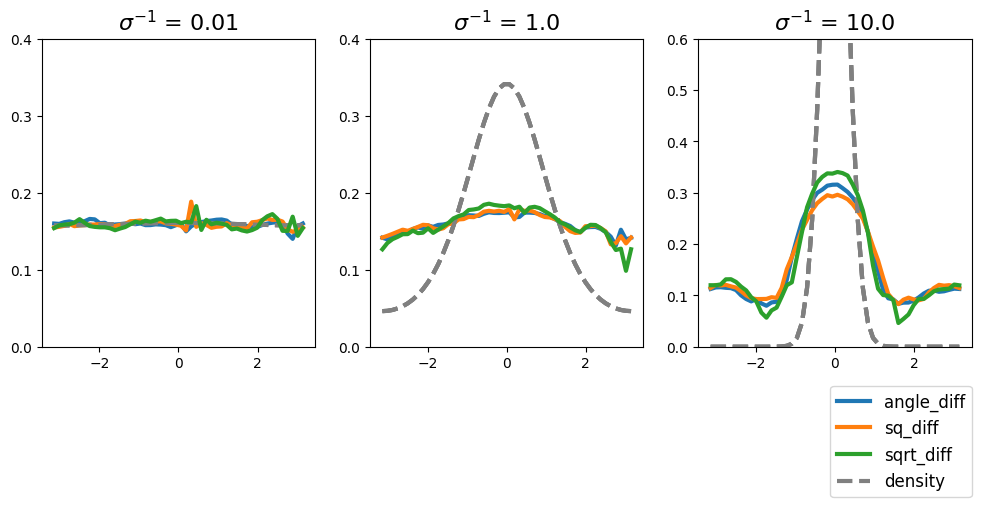

In [119]:
figsize(12,4)
plt.subplots(1,3)

color_dict = {loss: f'C{i}' for i, loss in enumerate(['angle_diff', 'sq_diff', 'sqrt_diff'])}
plt.ylim([0, 100])

for loss in ['angle_diff', 'sq_diff', 'sqrt_diff']:
    for i, row in enumerate(FI_data[FI_data.loss == loss ].sort_values('kappa').iterrows()):
        row = row[1]
        plt.subplot(1,3,i+1)
    
        dist = vonmises(loc=0, kappa=row['kappa'])
        plt.plot(angles, dist.pdf(angles), '--', color='0.5', linewidth=3, label='density')
        plt.ylim([0,0.4])
        plt.yticks(np.linspace(0, 0.4, 5))
        if i == 2:
            plt.ylim([0, 0.6])
            plt.yticks(np.linspace(0, 0.6, 7))
        
        plt.plot(angles, row['fisher_info']**0.5/a(row['fisher_info'].sum()*np.pi/25),
                 color=color_dict[row['loss']], linewidth=3, label=row['loss'])
        plt.title('$\sigma^{-1}$ = ' + f'{row['kappa']}', fontsize=16)

handles, labels = plt.gca().get_legend_handles_labels()
inds = [1,3,5,0]
handles = [handles[i] for i in inds]
labels = [labels[i] for i in inds]

plt.legend(handles, labels, bbox_to_anchor=(1.03, -.1), fontsize=12)

Equivalent probability densities:

<>:22: SyntaxWarning: invalid escape sequence '\s'
<>:22: SyntaxWarning: invalid escape sequence '\s'
/var/folders/_j/lst7wc811v14243bptx2xw640000gn/T/ipykernel_64735/3315136179.py:22: SyntaxWarning: invalid escape sequence '\s'
  plt.title('$\sigma^{-1}$ = ' + f'{row['kappa']}', fontsize=16)


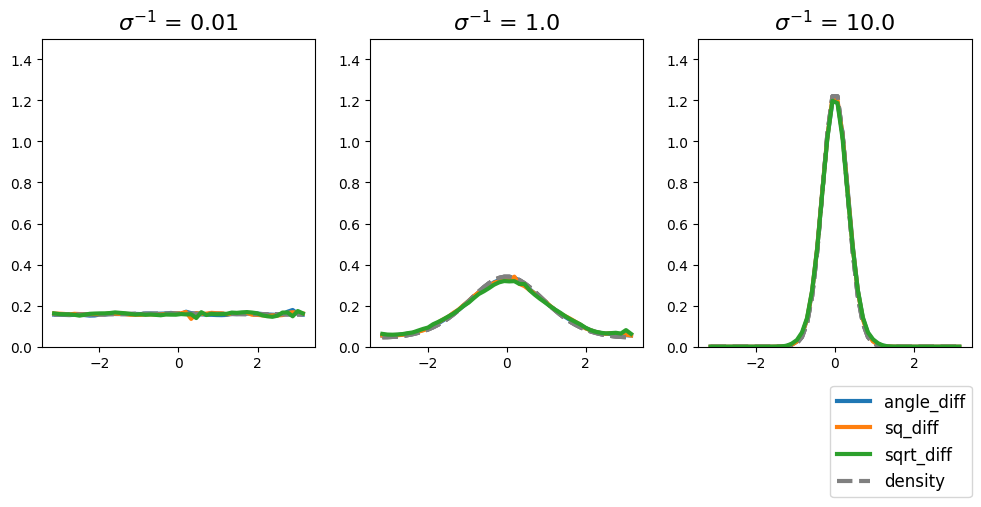

In [51]:
figsize(12,4)
plt.subplots(1,3)

color_dict = {loss: f'C{i}' for i, loss in enumerate(['angle_diff', 'sq_diff', 'sqrt_diff'])}
plt.ylim([0, 100])

for loss in ['angle_diff', 'sq_diff', 'sqrt_diff']:
    for i, row in enumerate(FI_data[FI_data.loss == loss ].sort_values('kappa').iterrows()):
        row = row[1]
        plt.subplot(1,3,i+1)
    
        dist = vonmises(loc=0, kappa=row['kappa'])
        prob_s = dist.pdf(angles)
        FIs = row['fisher_info']
        prob_theta = prob_s / (FIs / FIs.sum())**0.5
        prob_theta = prob_theta / (prob_theta.sum()*np.pi/25)
        
        
        plt.plot(angles, prob_s, '--', color='0.5', linewidth=3, label='density')
        
        plt.plot(angles, prob_theta, linewidth=3, label=row['loss'])
        plt.title('$\sigma^{-1}$ = ' + f'{row['kappa']}', fontsize=16)

        plt.ylim([0, 1.5])



handles, labels = plt.gca().get_legend_handles_labels()
inds = [1,3,5,0]
handles = [handles[i] for i in inds]
labels = [labels[i] for i in inds]

plt.legend(handles, labels, bbox_to_anchor=(1.03, -.1), fontsize=12)

Loss plots:

<>:19: SyntaxWarning: invalid escape sequence '\s'
<>:19: SyntaxWarning: invalid escape sequence '\s'
/var/folders/_j/lst7wc811v14243bptx2xw640000gn/T/ipykernel_64735/3833823960.py:19: SyntaxWarning: invalid escape sequence '\s'
  plt.title('$\sigma^{-1}$ = ' + f'{row['kappa']}', fontsize=16)


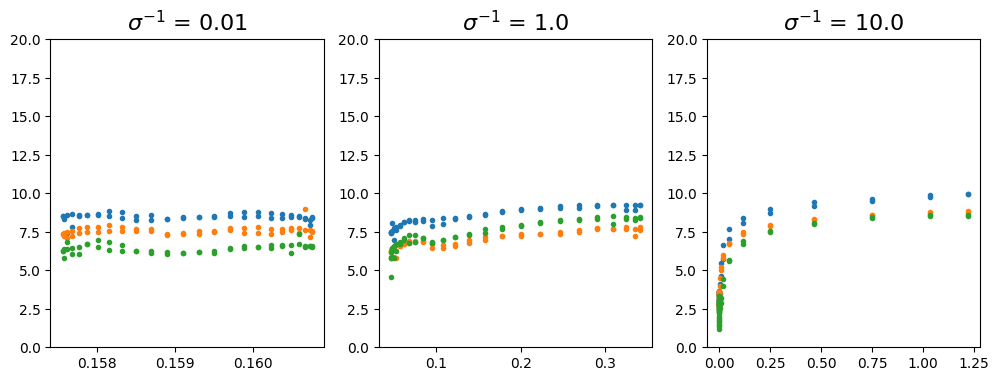

In [72]:
figsize(12,4)
plt.subplots(1,3)

color_dict = {loss: f'C{i}' for i, loss in enumerate(['angle_diff', 'sq_diff', 'sqrt_diff'])}
plt.ylim([0, 100])

for loss in ['angle_diff', 'sq_diff', 'sqrt_diff']:
    for i, row in enumerate(FI_data[FI_data.loss == loss ].sort_values('kappa').iterrows()):
        row = row[1]
        plt.subplot(1,3,i+1)
    
        dist = vonmises(loc=0, kappa=row['kappa'])
        prob_s = dist.pdf(angles)
        FIs = row['fisher_info']
        
        #plt.plot(angles, prob_s, '--', color='0.5', linewidth=3, label='density')
        
        plt.plot(prob_s, FIs**0.5, '.', linewidth=3, label=row['loss'])
        plt.title('$\sigma^{-1}$ = ' + f'{row['kappa']}', fontsize=16)


        plt.ylim(0, 20)



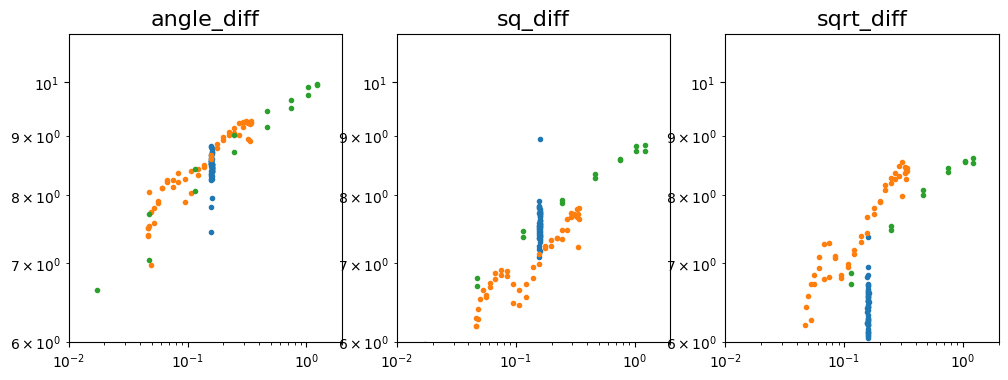

In [127]:
figsize(12,4)
plt.subplots(1,3)

color_dict = {loss: f'C{i}' for i, loss in enumerate(['angle_diff', 'sq_diff', 'sqrt_diff'])}

for i, loss in enumerate(['angle_diff', 'sq_diff', 'sqrt_diff']):
    for row in FI_data[FI_data.loss == loss ].sort_values('kappa').iterrows():
        row = row[1]
        plt.subplot(1,3,i+1)
    
        dist = vonmises(loc=0, kappa=row['kappa'])
        prob_s = dist.pdf(angles)
        FIs = row['fisher_info']
        
        plt.loglog(prob_s, FIs**0.5, '.', linewidth=3, label=row['loss'])
        plt.title(loss, fontsize=16)

        plt.xlim([1E-2, 2])
        plt.ylim(6, 11)
        


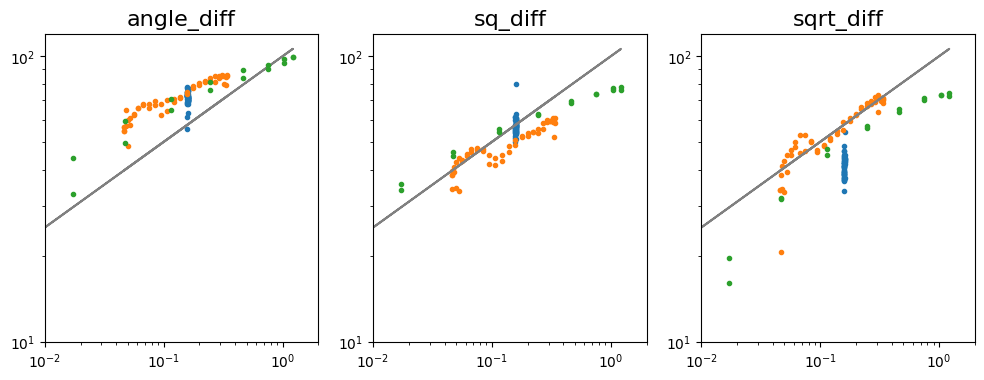

In [181]:
figsize(12,4)
plt.subplots(1,3)

for i, loss in enumerate(['angle_diff', 'sq_diff', 'sqrt_diff']):
    for row in FI_data[FI_data.loss == loss ].sort_values('kappa').iterrows():
        row = row[1]
        plt.subplot(1,3,i+1)
    
        dist = vonmises(loc=0, kappa=row['kappa'])
        prob_s = dist.pdf(angles)
        FIs = row['fisher_info']

        plt.loglog(prob_s, 100*(prob_s)**0.3, c='0.5')
        
        plt.loglog(prob_s, FIs, '.', linewidth=3, label=row['loss'])
        plt.title(loss, fontsize=16)


        plt.xlim([1E-2, 2])
        plt.ylim([1E1, 1.2E2])

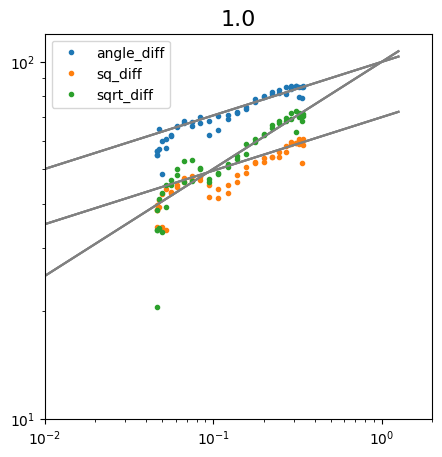

In [208]:
figsize(5,5)
for i, loss in enumerate(['angle_diff', 'sq_diff', 'sqrt_diff']):
    for row in FI_data[ (FI_data.loss == loss) & (FI_data.kappa == 1.0)  ].sort_values('kappa').iterrows():
        row = row[1]

        angles = np.linspace(-np.pi, np.pi)
        dist = vonmises(loc=0, kappa=row['kappa'])
        prob_s = dist.pdf(angles)
        FIs = row['fisher_info']
        
        plt.loglog(prob_s, FIs, '.', linewidth=3, label=row['loss'])
        plt.title(row['kappa'], fontsize=16)

        prob_base = np.logspace(-2, 0.1)
        plt.loglog(prob_base, 100*(prob_base)**0.3, c='0.5')

        prob_base = np.logspace(-2, 0.1)
        plt.loglog(prob_base, 100*(prob_base)**0.15, c='0.5')

        prob_base = np.logspace(-2, 0.1)
        plt.loglog(prob_base, 70*(prob_base)**0.15, c='0.5')

        plt.xlim([1E-2, 2])
        plt.ylim([1E1, 1.2E2])

plt.legend()

Maybe... maybe. It's very hard to tell from these plots. To test this, we need more data (more runs), more spread out in probability space.

The spread in probability space can also be addressed by evaluating Fisher information at more points.

__Important note:__ the measurements produce _root_ Fisher information.

In [1]:
figsize(5,5)
for i, loss in enumerate(['angle_diff', 'sq_diff', 'sqrt_diff']):
    for row in FI_data[ (FI_data.loss == loss) & (FI_data.kappa == 1.0)  ].sort_values('kappa').iterrows():
        row = row[1]

        angles = np.linspace(-np.pi, np.pi)
        dist = vonmises(loc=0, kappa=row['kappa'])
        prob_s = dist.pdf(angles)
        FIs = row['fisher_info']
        
        plt.loglog(prob_s, FIs**2, '.', linewidth=3, label=row['loss'])

plt.title(row['kappa'], fontsize=16)
plt.legend()

NameError: name 'figsize' is not defined

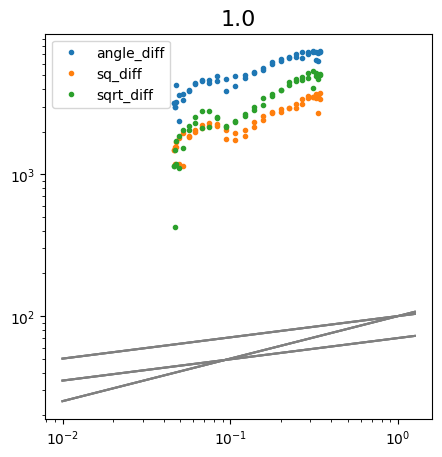

In [219]:
figsize(5,5)
for i, loss in enumerate(['angle_diff', 'sq_diff', 'sqrt_diff']):
    for row in FI_data[ (FI_data.loss == loss) & (FI_data.kappa == 1.0)  ].sort_values('kappa').iterrows():
        row = row[1]

        angles = np.linspace(-np.pi, np.pi)
        dist = vonmises(loc=0, kappa=row['kappa'])
        prob_s = dist.pdf(angles)
        FIs = row['fisher_info']
        
        plt.loglog(prob_s, FIs**2, '.', linewidth=3, label=row['loss'])
        plt.title(row['kappa'], fontsize=16)

        prob_base = np.logspace(-2, 0.1)
        plt.loglog(prob_base, 100*(prob_base)**0.3, c='0.5')

        prob_base = np.logspace(-2, 0.1)
        plt.loglog(prob_base, 100*(prob_base)**0.15, c='0.5')

        prob_base = np.logspace(-2, 0.1)
        plt.loglog(prob_base, 70*(prob_base)**0.15, c='0.5')

plt.legend()